Python for NLP: Multi-label Text Classification with Keras

Multi-label Text Classification Model with Single Output Layer

https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/ (english)

https://maelfabien.github.io/machinelearning/NLPfr/#7-embedding-par-mot (french - spacy)

Import data and libraries

In [1]:
import pandas as pd

#'Unnamed: 0' 'lemmes' 'pos'
X_train = pd.read_csv("../challenge_dataset/X_train_clean.csv").drop(columns='Unnamed: 0')

#'Id', 'category_1', 'category_2', 'category_3', 'category_4'
Y_train = pd.read_csv("../challenge_dataset/y_train.csv",sep=";").drop(columns="Id")

#'Id ', 'Caption'
X_test = pd.read_csv("../challenge_dataset/X_test.csv",sep=';').drop(columns='Id ')

In [2]:
X_test.columns

Index(['Caption'], dtype='object')

Necessary imports

In [3]:
#pip install tensorflow

from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import numpy as np
import re

import matplotlib.pyplot as plt

Shape and header

In [4]:
print(X_train.shape)

X_train.head()

(485, 2)


,lemmes,pos
0,"['mourir', 'heure', 'plus', 'revoir', 'petit',...","['VERB', 'NOUN', 'ADV', 'VERB', 'ADJ', 'NOUN']"
1,"['maladie', 'conséquence', 'jeune', 'génératio...","['NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN'..."
2,"['sortir', 'mal', 'loger']","['VERB', 'ADV', 'VERB']"
3,"['inquiétude', 'santé', 'proche', 'plus', 'fra...","['NOUN', 'ADJ', 'ADJ', 'ADV', 'ADJ', 'NOUN', '..."
4,"['bien', 'entendre', 'contracter', 'maladie']","['ADV', 'VERB', 'VERB', 'NOUN']"


Repartition of categories among training dataset

<AxesSubplot: >

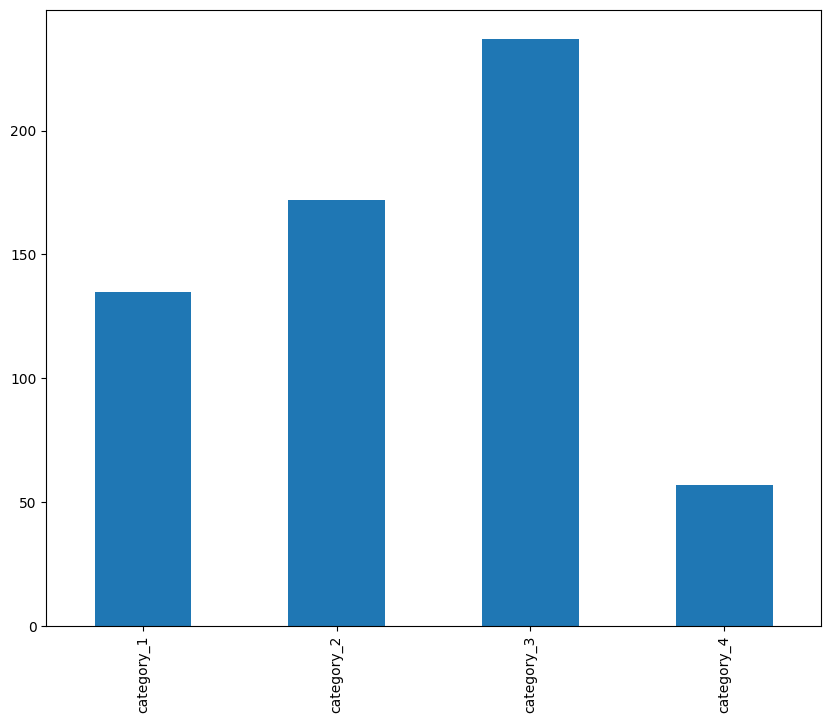

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Y_train.sum(axis=0).plot.bar()

Creating Multi-label Text Classification Models

Multi-label Text Classification Model with Single Output Layer

Pre-processing text

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Zéèàùï]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
X_train_cleaned = []

for sentences in X_train['lemmes']:
    X_train_cleaned.append(preprocess_text(sentences))

#print(X_train_cleaned)

Word embedding

In [8]:
#launch once or relaunch previous cell

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_cleaned)

X_train_cleaned = tokenizer.texts_to_sequences(X_train_cleaned)

#print(X_train_cleaned)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_cleaned = pad_sequences(X_train_cleaned, padding='post', maxlen=maxlen)

#print(X_train_cleaned)

Training 80% testing 20%

In [9]:
X = X_train_cleaned
Y = Y_train

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(388, 200)
(388, 4)
(97, 200)
(97, 4)


Word embedding (french)

https://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html

In [11]:
from numpy import array, asarray, zeros

In [12]:
embeddings_dictionary = dict()

glove_file = open('../resources/multilingual_embeddings.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
#print(embedding_matrix)

NN model

In [14]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

#4 labels -> 4 neurons
dense_layer_1 = Dense(4, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Summary of the NN

In [15]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          520500    
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 740,664
Trainable params: 220,164
Non-trainable params: 520,500
_________________________________________________________________
None


Architecture of the NN

In [16]:
from keras.utils import plot_model

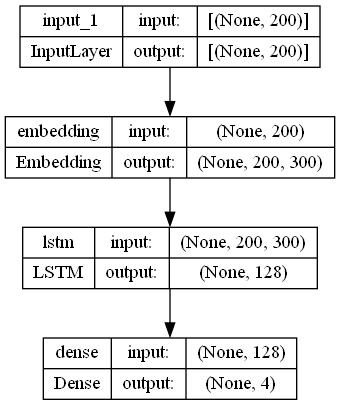

In [17]:
#pip install pydot
#https://graphviz.gitlab.io/download/

plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Train model

In [18]:
history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
10/10 [==============================] - 6s 280ms/step - loss: 0.6695 - acc: 0.3226 - val_loss: 0.6293 - val_acc: 0.3718
Epoch 2/5
10/10 [==============================] - 2s 196ms/step - loss: 0.5791 - acc: 0.3419 - val_loss: 0.6030 - val_acc: 0.3718
Epoch 3/5
10/10 [==============================] - 2s 201ms/step - loss: 0.5675 - acc: 0.3419 - val_loss: 0.6054 - val_acc: 0.3718
Epoch 4/5
10/10 [==============================] - 2s 211ms/step - loss: 0.5668 - acc: 0.3419 - val_loss: 0.5979 - val_acc: 0.3718
Epoch 5/5
10/10 [==============================] - 2s 193ms/step - loss: 0.5653 - acc: 0.3419 - val_loss: 0.5995 - val_acc: 0.3718


Evaluate model

In [19]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

4/4 [==============================] - 0s 53ms/step - loss: 0.5899 - acc: 0.3196
Test Score: 0.5898923873901367
Test Accuracy: 0.3195876181125641
